In [45]:
from typing import Dict, List

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer, TweetTokenizer
from sklearn.metrics import f1_score, recall_score, classification_report, ConfusionMatrixDisplay
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [41]:
## Раскомментируйте и скачайте эмбеддинги
# aria2c is just faster than wget because it uses multiple threads
!aria2c -x 16 -j 16 -s 16 https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz


10/26 20:24:07 [NOTICE] Downloading 1 item(s)
[#ddf9ed 1.2GiB/1.2GiB(99%) CN:2 DL:30MiB]0m]mmm
10/26 20:24:38 [NOTICE] Download complete: /workspace/notebooks/DeepAverageNetwork/cc.en.300.vec.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
ddf9ed|OK  |    41MiB/s|/workspace/notebooks/DeepAverageNetwork/cc.en.300.vec.gz

Status Legend:
(OK):download completed.


In [2]:
def load_embeddings(path: str, num_tokens=100_000):
    
    pad_token = "<PAD>"
    unk_token = "<UNK>"

    vocab: Dict[str, int] = dict()
    embeddings = list()

    with open(path) as f:

        vocab_size, embedding_dim = f.readline().strip().split()

        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        max_words = vocab_size if num_tokens <= 0 else num_tokens+2

        vocab[pad_token] = 0
        embeddings.append(np.zeros(embedding_dim))

        vocab[unk_token] = 1
        embeddings.append(np.ones(embedding_dim))

        progress_bar = tqdm(total=max_words-2, desc='Reading embeddings file')

        for line in f:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token in vocab:
                continue

            word_vector = np.array(list(map(float, parts[-embedding_dim:])))

            vocab[token] = len(vocab)
            embeddings.append(word_vector)

            progress_bar.update()

            if len(vocab) == max_words:
                break

        progress_bar.close()

    embeddings = np.stack(embeddings)
    
    return vocab, embeddings
    
    assert(len(vocab) == embeddings.shape[0])
    
    return vocab, embeddings

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [3]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


In [23]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        indexes = []
        for token in tokenized_text:
            if token in self.token2index:
                indexes.append(self.token2index[token])
            else:
                indexes.append(self.unk_index)
        return indexes
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        padded_indexes = [self.pad_index] * self.max_length
        unpadded_indexes = tokens_indices if len(tokens_indices) <= self.max_length else tokens_indices[:self.max_length]
        for i, idx in enumerate(unpadded_indexes):
            padded_indexes[i] = idx
            
        return padded_indexes
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        return self.padding(self.indexing(self.tokenize(text)))
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample['text']))
            labels.append(sample['label'])
            
        tokenized_texts = torch.LongTensor(tokenized_texts)  # перевод в torch.Tensor
        labels = torch.LongTensor(labels)  # перевод в torch.Tensor
        
        return tokenized_texts, labels

In [24]:
token2index, embeddings = load_embeddings("cc.en.300.vec", 500000)
base_tokenizer = TweetTokenizer(reduce_len=True)
tokenizer = Tokenizer(base_tokenizer, token2index, "<PAD>", "<UNK>", 128)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=tokenizer.collate)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=tokenizer.collate)

Reading embeddings file:   0%|          | 0/500000 [00:00<?, ?it/s]

In [9]:
for x, y in train_loader:
    break

In [10]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Я выбрал метрику Macro-Recall
Почему я выбрал эту метрику:
Выбрал эту метрику потому что в статье (https://aclanthology.org/2020.findings-emnlp.148.pdf) она указывается как evaluation метрика для датасета sentiment. Macro-averaging позволит получать более честные показатели качества вне зависимости от наличия или отсутствия дизбаланса классов.

In [53]:
import torch.nn.functional as F


class DeepAverageNetwork(nn.Module):
    def __init__(self, embedding_matrix, dropout_prob: float = 0.5):
        super().__init__()
        self.embeddings = nn.EmbeddingBag.from_pretrained(
            embeddings=torch.from_numpy(embedding_matrix).to(torch.float32),
            mode='mean',
            padding_idx=0,
            max_norm=10.0,
            freeze=False,
        )
        
        self.linear1 = nn.Linear(in_features=embedding_matrix.shape[1], out_features=256)
        self.output = nn.Linear(in_features=256, out_features=3)
        self.bn1 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        data = self.drop(self.embeddings(x))
        
        data = self.drop(self.bn1(F.mish(self.linear1(data))))
        
        
        return self.output(data)
        

In [54]:
model = DeepAverageNetwork(embeddings)

In [55]:
device = torch.device("cuda:0")
model = model.to(device)
model

DeepAverageNetwork(
  (embeddings): EmbeddingBag(500002, 300, max_norm=10.0, mode=mean, padding_idx=0)
  (linear1): Linear(in_features=300, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=3, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)

## Задайте функцию потерь и оптимизатор

In [56]:
from transformers.optimization import get_cosine_schedule_with_warmup
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

## Сделайте цикл обучения

In [60]:
NUM_EPOCHS = 15  # Задайте количество эпох
log_frequency = 70
train_loss = []
train_recall = []
val_loss = []
val_recall = []

warmup_ratio = 0.3
num_training_steps = len(train_loader) * NUM_EPOCHS
num_warmup = int(round(num_training_steps * warmup_ratio))

lr_sched = get_cosine_schedule_with_warmup(optimizer=optim, num_training_steps=num_training_steps, num_warmup_steps=num_warmup)

for n_epoch in range(NUM_EPOCHS):
    
    y_pred = []
    y_true = []
    epoch_loss = []
    for i, (x, y) in enumerate(tqdm(train_loader, desc=f"Train Epoch {n_epoch}")):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss_value = loss(logits, y)
        loss_value.backward()
        optim.step()
        lr_sched.step()
        optim.zero_grad()
        
        epoch_loss.append(loss_value.item())
        
        with torch.no_grad():
            y_pred_batch = torch.argmax(torch.softmax(logits, -1), -1)
            y_pred_batch = y_pred_batch.detach().cpu().numpy()
            y_true_batch = y.detach().cpu().numpy()
            
            y_pred += list(y_pred_batch)
            y_true += list(y_true_batch)
            if i % log_frequency == 0:
                recall = recall_score(y_true_batch, y_pred_batch, average='macro')
                print(f"Macro Recall: {recall:.4f} | Loss: {loss_value.item():.4f}")
                
    train_loss.append(np.mean(epoch_loss))
    ep_train_recall = recall_score(y_true, y_pred, average='macro')
    train_recall.append(ep_train_recall)

    # validation
    epoch_val_loss = []
    with torch.no_grad():
        y_pred = []
        y_true = []
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            epoch_val_loss.append(loss(logits, y).item())
            y_pred_batch = torch.argmax(torch.softmax(logits, -1), -1).cpu().numpy()
            y_true_batch = y.cpu().numpy()
            
            y_pred += list(y_pred_batch)
            y_true += list(y_true_batch)
            
        ep_val_recall = recall_score(y_true, y_pred, average='macro')
        val_recall.append(ep_val_recall)
        val_loss.append(np.mean(epoch_val_loss))
    
    print("=="*40)
    print(f"Train Recall: {ep_train_recall:^5} | Val Recall: {ep_val_recall:^5}")
    print(f"Train Loss:   {np.mean(epoch_loss):^5} | Val Loss: {np.mean(epoch_val_loss):^5}")
    print("=="*40)
    
# test
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Testing...'):
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        y_pred_batch = torch.argmax(torch.softmax(logits, -1), -1).cpu().numpy()
        y_true_batch = y.cpu().numpy()

        y_pred += list(y_pred_batch)
        y_true += list(y_true_batch)
        
test_recall = recall_score(y_true, y_pred, average='macro')
print("++"*40)
print(f"Test Recall: {test_recall:.4f}")
print("++"*40)

Train Epoch 0:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.7673 | Loss: 0.5750
Macro Recall: 0.7527 | Loss: 0.4889
Macro Recall: 0.7292 | Loss: 0.5584
Macro Recall: 0.7948 | Loss: 0.4877
Macro Recall: 0.6637 | Loss: 0.6695
Macro Recall: 0.6931 | Loss: 0.5835
Train Recall: 0.7222542874698018 | Val Recall: 0.5783691226729202
Train Loss:   0.5958735207382705 | Val Loss: 0.8937701396644115


Train Epoch 1:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.7482 | Loss: 0.5228
Macro Recall: 0.7470 | Loss: 0.4708
Macro Recall: 0.7672 | Loss: 0.5208
Macro Recall: 0.7301 | Loss: 0.6854
Macro Recall: 0.7573 | Loss: 0.5903
Macro Recall: 0.7312 | Loss: 0.5823
Train Recall: 0.7227410157242319 | Val Recall: 0.5694498305257799
Train Loss:   0.5955523467865311 | Val Loss: 0.8987070210278034


Train Epoch 2:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.6867 | Loss: 0.5902
Macro Recall: 0.7340 | Loss: 0.5473
Macro Recall: 0.7872 | Loss: 0.4877
Macro Recall: 0.7339 | Loss: 0.5537
Macro Recall: 0.7799 | Loss: 0.4626
Macro Recall: 0.6400 | Loss: 0.6486
Train Recall: 0.7263524601657144 | Val Recall: 0.5618541093224637
Train Loss:   0.5896269705783085 | Val Loss: 0.9086225815117359


Train Epoch 3:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.6921 | Loss: 0.5278
Macro Recall: 0.7075 | Loss: 0.5849
Macro Recall: 0.6799 | Loss: 0.6431
Macro Recall: 0.6951 | Loss: 0.6491
Macro Recall: 0.7230 | Loss: 0.5186
Macro Recall: 0.7845 | Loss: 0.5962
Train Recall: 0.7314144413241598 | Val Recall: 0.5702282949118392
Train Loss:   0.583167428562955 | Val Loss: 0.9338757544755936


Train Epoch 4:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.7559 | Loss: 0.5504
Macro Recall: 0.7135 | Loss: 0.5736
Macro Recall: 0.7965 | Loss: 0.5482
Macro Recall: 0.7737 | Loss: 0.4943
Macro Recall: 0.7538 | Loss: 0.5143
Macro Recall: 0.7347 | Loss: 0.6324
Train Recall: 0.7392948673019144 | Val Recall: 0.5598255471673194
Train Loss:   0.5708809673619204 | Val Loss: 0.969649001955986


Train Epoch 5:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.8445 | Loss: 0.4704
Macro Recall: 0.8106 | Loss: 0.5158
Macro Recall: 0.7773 | Loss: 0.5068
Macro Recall: 0.7323 | Loss: 0.4639
Macro Recall: 0.7387 | Loss: 0.5516
Macro Recall: 0.7173 | Loss: 0.6142
Train Recall: 0.7488325507079723 | Val Recall: 0.5678088905937008
Train Loss:   0.5524403551379505 | Val Loss: 0.9772221222519875


Train Epoch 6:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.7900 | Loss: 0.5943
Macro Recall: 0.7829 | Loss: 0.4443
Macro Recall: 0.8218 | Loss: 0.4750
Macro Recall: 0.8071 | Loss: 0.4673
Macro Recall: 0.7609 | Loss: 0.5798
Macro Recall: 0.7081 | Loss: 0.5816
Train Recall: 0.7578751356897246 | Val Recall: 0.5715332487484387
Train Loss:   0.533456915733861 | Val Loss: 0.9732252210378647


Train Epoch 7:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.8331 | Loss: 0.4781
Macro Recall: 0.7897 | Loss: 0.4474
Macro Recall: 0.7707 | Loss: 0.5443
Macro Recall: 0.8182 | Loss: 0.4855
Macro Recall: 0.8057 | Loss: 0.5434
Macro Recall: 0.6855 | Loss: 0.6372
Train Recall: 0.77083445028148 | Val Recall: 0.5549722195291815
Train Loss:   0.5146779551559469 | Val Loss: 1.0257541984319687


Train Epoch 8:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.7940 | Loss: 0.4570
Macro Recall: 0.8460 | Loss: 0.3909
Macro Recall: 0.8178 | Loss: 0.4544
Macro Recall: 0.7673 | Loss: 0.5412
Macro Recall: 0.8319 | Loss: 0.4592
Macro Recall: 0.7850 | Loss: 0.5135
Train Recall: 0.7807107868203533 | Val Recall: 0.5582354822861152
Train Loss:   0.4981564911139779 | Val Loss: 1.0450151711702347


Train Epoch 9:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.8077 | Loss: 0.4640
Macro Recall: 0.7381 | Loss: 0.5459
Macro Recall: 0.8009 | Loss: 0.5154
Macro Recall: 0.8014 | Loss: 0.4318
Macro Recall: 0.8799 | Loss: 0.4055
Macro Recall: 0.7781 | Loss: 0.4369
Train Recall: 0.7888682048497432 | Val Recall: 0.573706356934205
Train Loss:   0.48247334519688156 | Val Loss: 1.0920395851135254


Train Epoch 10:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.7819 | Loss: 0.4676
Macro Recall: 0.8422 | Loss: 0.4015
Macro Recall: 0.8111 | Loss: 0.4248
Macro Recall: 0.7862 | Loss: 0.5513
Macro Recall: 0.7018 | Loss: 0.5499
Macro Recall: 0.8135 | Loss: 0.4711
Train Recall: 0.7944935597604896 | Val Recall: 0.5694053953547624
Train Loss:   0.46672896644314465 | Val Loss: 1.1065258495509624


Train Epoch 11:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.9055 | Loss: 0.3394
Macro Recall: 0.8113 | Loss: 0.4746
Macro Recall: 0.6709 | Loss: 0.5427
Macro Recall: 0.8425 | Loss: 0.3663
Macro Recall: 0.7653 | Loss: 0.5388
Macro Recall: 0.8557 | Loss: 0.3927
Train Recall: 0.7992947527732377 | Val Recall: 0.5593539137842934
Train Loss:   0.458872696431745 | Val Loss: 1.1473278924822807


Train Epoch 12:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.8688 | Loss: 0.3308
Macro Recall: 0.8126 | Loss: 0.3969
Macro Recall: 0.7974 | Loss: 0.4699
Macro Recall: 0.8234 | Loss: 0.4078
Macro Recall: 0.8149 | Loss: 0.3979
Macro Recall: 0.7806 | Loss: 0.5387
Train Recall: 0.8034676759022915 | Val Recall: 0.5574925543279974
Train Loss:   0.44890326720659807 | Val Loss: 1.1460245065391064


Train Epoch 13:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.8224 | Loss: 0.4130
Macro Recall: 0.8280 | Loss: 0.4384
Macro Recall: 0.7239 | Loss: 0.5226
Macro Recall: 0.8196 | Loss: 0.4001
Macro Recall: 0.7561 | Loss: 0.4639
Macro Recall: 0.8327 | Loss: 0.4349
Train Recall: 0.8062532056483726 | Val Recall: 0.5517969489488477
Train Loss:   0.44574729902069776 | Val Loss: 1.1422088965773582


Train Epoch 14:   0%|          | 0/357 [00:00<?, ?it/s]

Macro Recall: 0.8095 | Loss: 0.4445
Macro Recall: 0.8742 | Loss: 0.3574
Macro Recall: 0.7819 | Loss: 0.5080
Macro Recall: 0.7840 | Loss: 0.4658
Macro Recall: 0.8296 | Loss: 0.3482
Macro Recall: 0.8036 | Loss: 0.5422
Train Recall: 0.8081457011673017 | Val Recall: 0.557209902146611
Train Loss:   0.44476676680126775 | Val Loss: 1.1629686951637268


Testing...:   0%|          | 0/96 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Test Recall: 0.5106
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [61]:
print(classification_report(y_true, y_pred, target_names=train_dataset.features['label'].names))

              precision    recall  f1-score   support

    negative       0.64      0.28      0.39      3972
     neutral       0.57      0.55      0.56      5937
    positive       0.35      0.70      0.46      2375

    accuracy                           0.49     12284
   macro avg       0.52      0.51      0.47     12284
weighted avg       0.55      0.49      0.49     12284



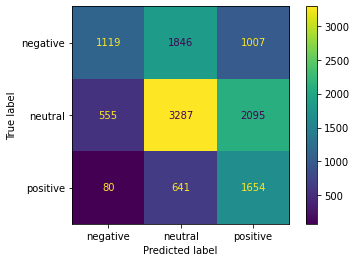

In [62]:
cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=train_dataset.features['label'].names)

# Выводы
Напишите небольшой отчет о проделанной работе. Что удалось, в чем не уверены, что делать дальше.

- Получилось сделать модель с предлагаемой архитектурой
- Получилось реализовать процесс предобработки текста и процесс обучения
- Модель не позволяет добится каких-то серьезных результатов и переобучается несмотря на применение dropout и batchnorm
- Качество работы модели в общем случае не зависит от глубины MLP-компоненты, достаточно и одного слоя внутри + выходного слоя
- Чаще всего модель путает нейтральный сентимент с позитивным, негативный с нейтральным и негативный с позитивным
- Возможно стоит добавить способ учитывать контекст или позицию токенов(можно попробовать добавить позиционные эмбеддинги как в трансформерах) или добавить кастомные веса для классов в лосс-функцию.
- Ввиду того что в токенизированном тексте полно UNK-токенов, то думаю стоит добавить посимвольные эмбеддинги + посимвольную cnn(как реализовано в elmo в allennlp)
- С другой стороны это очень простая модель, мб не стоит ожидать от нее хороших результатов.
- Так-же возможны пробелы в разметке нейтрального и негативного классов, в то время как позитивный класс размечен хорошо и модель реже всего путает его с каким-то другим классом